In [2]:
from collections import OrderedDict
from typing import Callable, Union

from time import time
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.optim
import torch.nn as nn
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F

import hxtorch
import _hxtorch
import hxtorch.nn as hxnn

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import quantized_cINN.common as com

## generate some data

In [3]:
class ExampleDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=100000, img_size=(2, 2), transform=None):
        self.n_samples = n_samples
        self.img_size = img_size
        self.transform = transform
        self.data, self.targets = self._generate_data()

    def _generate_data(self):
        floor = 0.2
        intensity = (0, 1)

        high = self.img_size[0] * self.img_size[1]
        labels = torch.randint(low=0, high=high, size=(self.n_samples, ))
        imgs = floor * torch.rand((self.n_samples, 1, *self.img_size))
        imgs[torch.arange(self.n_samples), :, labels%2, labels//2] += intensity[1] - floor 
        return imgs, labels

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        X = self.data[idx].numpy()
        y = self.targets[idx].reshape(-1).numpy()
        if self.transform:
            X = self.transform(X)
        return X, y

class ExampleData:

    def __init__(self, config: object):
        from torch.utils.data import Dataset, DataLoader, TensorDataset
        import torchvision.transforms as T

        self.c = config

        self.train_data = ExampleDataset(transform=T.ToTensor())
        self.test_data = ExampleDataset(transform=T.ToTensor())

        # Sample a fixed batch of 1024 validation examples
        self.val_x, self.val_l = zip(*list(self.train_data[i] for i in range(1024)))
        self.val_x = torch.stack(self.val_x, 0).to(config.device)
        self.val_l = torch.LongTensor(self.val_l).to(config.device)

        # Exclude the validation batch from the training data
        self.train_data.data = self.train_data.data[1024:]
        self.train_data.targets = self.train_data.targets[1024:]

        ## Add the noise-augmentation to the (non-validation) training data:
        #augm_func = lambda x: x + self.c.add_image_noise * torch.randn_like(x)
        #self.train_data.transform = T.Compose([self.train_data.transform, augm_func])

        self.train_loader = DataLoader(self.train_data,
                                       batch_size=self.c.batch_size,
                                       shuffle=True,
                                       num_workers=self.c.n_workers,
                                       pin_memory=True, drop_last=True)
        self.test_loader = DataLoader(self.test_data,
                                      batch_size=self.c.batch_size,
                                      shuffle=False,
                                      num_workers=self.c.n_workers,
                                      pin_memory=True, drop_last=True)

## configuaration

In [4]:
class CONFIG(com.baseCONFIG):
    """
    Namspace for configuration
    """
    # Data
    data_mean = None
    data_std = None
    add_image_noise = None

    img_size = (2, 2)
    device = "cpu"
    n_workers = 8

    mock = False

    # Training
    lr = 1e-3
    batch_size = 256
    weight_decay = 1e-5
    gamma = 0.1
    milestones = [20, 40]
    betas = (0.9, 0.999)

    n_epochs = 1

    init_scale = 0.03
    pre_low_lr = 0
    
    clip_grad_norm = 100.0

    # Architecture
    n_blocks = 8
    internal_width = 16
    clamping = 1.
    fc_dropout = 0.0

    # Logging/preview
    loss_names = ['L']
    preview_upscale = 3                         # Scale up the images for preview
    sampling_temperature = 0.8                  # Sample at a reduced temperature for the preview
    progress_bar = True                         # Show a progress bar of each epoch
    eval_steps_interploation = 12
    eval_seeds_interpolation  = (51, 89)

    # Validation
    pca_weights = [
        [(0,0.55)],
        [(1,0.1), (3, 0.4), (4, 0.5)],
        [(2,0.33), (3, 0.33), (1, -0.33)]]
    pca_gridsize = 10
    pca_extent = 8.


    # Paths
    mnist_data = "../mnist_data"
    save_dir = "out/hx_mock/"

    load_file = "out/hx_mock/hx_mock_example_checkpoint.pt"
    filename = "out/hx_mock/hx_mock_example_cinn.pt"

    checkpoint_save_interval =  50
    checkpoint_save_overwrite = True
    checkpoint_on_error = True

## model

In [5]:
class HXCouplingBlock(Fm.coupling_layers._BaseCouplingBlock):
    '''
    '''

    def __init__(self, dims_in, dims_c=[],
                 subnet_constructor: Callable = None):
        '''
        Additional args in docstring of base class.

        Args:
          subnet_constructor: function or class, with signature
            constructor(dims_in, dims_out).  The result should be a torch
            nn.Module, that takes dims_in input channels, and dims_out output
            channels. See tutorial for examples. Two of these subnetworks will be
            initialized in the block.
          clamp: Soft clamping for the multiplicative component. The
            amplification or attenuation of each input dimension can be at most
            exp(±clamp).
          clamp_activation: Function to perform the clamping. String values
            "ATAN", "TANH", and "SIGMOID" are recognized, or a function of
            object can be passed. TANH behaves like the original realNVP paper.
            A custom function should take tensors and map -inf to -1 and +inf to +1.
        '''

        super().__init__(dims_in, dims_c, clamp=None, clamp_activation=(lambda u: u))

        self.subnet1 = subnet_constructor(self.split_len1 + self.condition_length, self.split_len2 * 2)
        self.subnet2 = subnet_constructor(self.split_len2 + self.condition_length, self.split_len1 * 2)

    def _coupling1(self, x1, u2, rev=False):

        assert torch.min(x1) >= 0, f"need x1 >= 0 but is in min {torch.min(x1)}"
        assert torch.max(x1) <= 1, f"need x1 <= 1 but is in min {torch.max(x1)}"
        assert torch.min(u2) >= 0, f"need u2 >= 0 but is in min {torch.min(u2)}"
        assert torch.max(u2) <= 1, f"need u2 <= 1 but is in min {torch.max(u2)}"

        # input shift (0, 1] -> (0, 31]
        a2 = self.subnet2(u2 * 31.)
        assert torch.min(a2) >= -128, f"need subnet_out_2 >= -128 but is in min {torch.min(a2)}"
        assert torch.max(a2) <= 127, f"need subnet_out_2 <= 127 but is in min {torch.max(a2)}"

        # output shift [-128, 127] -> (0, 0.5]
        a2 = (a2 + 129) / (256 * 2)

        s2, t2 = a2[:, :self.split_len1], a2[:, self.split_len1:]
        j1 = torch.sum(torch.log(s2), dim=tuple(range(1, self.ndims + 1)))

        if rev:
            y1 = torch.clamp(x1 - t2, 1 / 256, 1) / s2
            return y1, -j1
        else:
            y1 = s2 * x1 + t2
            return y1, j1

    def _coupling2(self, x2, u1, rev=False):

        assert torch.min(x2) >= 0, f"need x2 >= 0 but is in min {torch.min(x2)}"
        assert torch.max(x2) <= 1, f"need x2 <= 1 but is in min {torch.max(x2)}"
        assert torch.min(u1) >= 0, f"need u1 >= 0 but is in min {torch.min(u1)}"
        assert torch.max(u1) <= 1, f"need u1 <= 1 but is in min {torch.max(u1)}"

        # input shift (0, 1] -> (0, 31]
        a1 = self.subnet1(u1 * 31.)
        assert torch.min(a1) >= -128, f"need subnet_out_1 >= -128 but is in min {torch.min(a1)}"
        assert torch.max(a1) <= 127, f"need subnet_out_1 <= 127 but is in min {torch.max(a1)}"

        # output shift [-128, 127] -> (0, 0.5]
        a1 = (a1 + 129) / (256 * 2)

        s1, t1 = a1[:, :self.split_len2], a1[:, self.split_len2:]
        j2 = torch.sum(torch.log(s1), dim=tuple(range(1, self.ndims + 1)))

        if rev:
            y2 = torch.clamp(x2 - t1, 1 / 256, 1) / s1
            return y2, -j2
        else:
            y2 = s1 * x2 + t1
            return y2, j2

In [5]:
from torch.nn.parameter import Parameter

class LinearScaling(nn.Module):

    def __init__(self, weight: float=1., bias: float=0.,
                 outrange=None, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(LinearScaling, self).__init__()

        self.weight = Parameter(torch.tensor(weight), requires_grad=True)
        self.bias = Parameter(torch.tensor(bias), requires_grad=True)
        self.outrange = outrange

    def forward(self, x):
        x = x * self.weight + self.bias
        if self.outrange:
            x = x.clamp(*self.outrange)
        return x

class MinMaxScaling(nn.Module):

    def __init__(self, outrange, per_feature=False, size=None):
        #assert (per_feature and not size) "If you want per_feature "
        super(MinMaxScaling, self).__init__()
        if size:
            self.weight = torch.ones(size)
            self.bias = torch.zeros(size)
            self.per_feature = per_feature
        else:
            self.weight = torch.ones(1)
            self.bias = torch.zeros(1)
            self.per_feature = False
        #self.register_parameter("factor__", None)
        #self.register_parameter("bias__", None)

        self.outrange = outrange
        self.in_min = None
        self.in_max = None

    def forward(self, x):
        if self.training:
            if self.per_feature:
                self.in_min = torch.min(x, axis=0)[0]
                self.in_max = torch.max(x, axis=0)[0]
            else:
                self.in_min = torch.tensor([torch.min(x)])
                self.in_max = torch.tensor([torch.max(x)])

        _norm = self.in_max - self.in_min
        self.weight = (self.outrange[1] - self.outrange[0]) / _norm
        self.bias = self.outrange[1] - self.weight * self.in_max
        return self.weight * x + self.bias     
        
        
class Scale(nn.Module):
    def __init__(self, scale=1):
        super(Scale, self).__init__()
        self.scale = scale
        
    def forward(self, x):
        x = x * self.scale
        return x
    
class DynamicScaling(nn.Module):
    r"""Applies a linear scaling to the incoming data: :math:`y = x*w + b`
    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
    Args:
        features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``
    Shape:
        - Input: :math:`(N, *, H)` where :math:`*` means any number of
          additional dimensions and :math:`H = \text{features}`.
        - Output: :math:`(N, *, H)`.
    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`
    """
    __constants__ = ['features']
    features: int
    weight: torch.Tensor

    def __init__(self, features: int, bias: bool = True,
                device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(DynamicScaling, self).__init__()
        self.features = features

        self.weight = Parameter(torch.empty(features, **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters_static()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(torch.diag(self.weight), a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(torch.diag(self.weight))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
            
    def reset_parameters_static(self) -> None:
        nn.init._no_grad_fill_(self.weight, 0.03)
        nn.init.zeros_(self.bias)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, torch.diag(self.weight), self.bias)

    def extra_repr(self) -> str:
        return 'features={}, bias={}'.format(
            self.features, self.bias is not None
        )
    
class FixedRangeScaling(nn.Module):
    r"""
    """
    __constants__ = ['features', 'max_out']
    per_feature: bool
    features: int
    max_out: int
    weight: torch.Tensor

    def __init__(self, features: int, max_out: int, per_feature: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FixedRangeScaling, self).__init__()
        self.features = features
        self.max_out = max_out
        self.per_feature = per_feature

        self.weight = Parameter(torch.empty(features, **factory_kwargs),
                                requires_grad=False)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.ones_(self.weight)

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        if self.training:
            max_abs, _ = torch.max(torch.abs(input_), axis=0)
            if not self.per_feature:
                max_abs.fill_(max_abs.max())
            max_abs[max_abs == 0.] = self.max_out
            #nn.init._no_grad_fill_(self.weight, self.max_out / max_abs)
            self.weight = nn.Parameter(self.max_out / max_abs, requires_grad=False)
        return F.linear(input_, torch.diag(self.weight))
            
            #max_abs = torch.max(torch.abs(input_), axis=0)
            #factor = _hxtorch.constants.input_activation_max / max_abs.values if max_abs.values != 0 else 1
        #return input_ * factor

    def extra_repr(self) -> str:
        return 'features={}, max_out={}, per_feature={}'.format(
            self.features, self.max_out, self.per_feature
        )

In [6]:
class EXAMPLEcINN_hx(nn.Module):
    """
    """

    def __init__(self, config: object=CONFIG):
        super().__init__()
        #self.stop = False

        self.c = config

        self.cinn = self.build_inn()

        self.trainable_parameters = []
        for name, param in self.cinn.named_parameters():
            #print(name, (name.split(".")[-2][-2:] == "__"))
            if param.requires_grad and not (name.split(".")[-2][-2:] == "__"):
                #print("accept")
                self.trainable_parameters.append(param)
            continue

        #for p in self.trainable_parameters:
        #    print(p)
        #    p.data = self.c.init_scale * torch.randn_like(p)

        self.cinn.to(self.c.device)

        self.optimizer = torch.optim.Adam(self.trainable_parameters,
                                          lr=self.c.lr,
                                          weight_decay=self.c.weight_decay)
        self.weight_scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer,
                                                                #step_size=1,
                                                                milestones=self.c.milestones,
                                                                gamma=self.c.gamma)

    def build_inn(self):
        
        def scale_input_total(x_in: torch.Tensor) -> torch.Tensor:
            max_abs = torch.max(torch.abs(x_in))
            factor = _hxtorch.constants.input_activation_max / max_abs if max_abs != 0 else 1
            return x_in * factor

        def fc_subnet(ch_in, ch_out):
            net = OrderedDict([
                #("hx_input__", MinMaxScaling((0., 31.), per_feature=True)),
                ("hx_input1", FixedRangeScaling(features=ch_in,
                                                max_out=31,
                                                per_feature=True)),
                ("hx_lin_1", hxnn.Linear(in_features=ch_in,
                                         out_features=self.c.internal_width,
                                         bias=False,
                                         num_sends=2,
                                         wait_between_events=2,
                                         mock=self.c.mock,
                                         signed_input=True,
                                         )),
                ("relu1", hxnn.ConvertingReLU(shift=1,
                                              mock=True)),
                ("hx_input2", FixedRangeScaling(features=self.c.internal_width,
                                                max_out=31,
                                                per_feature=True)),
                ("hx_lin_2", hxnn.Linear(in_features=self.c.internal_width,
                                         out_features=ch_out,
                                         bias=False,
                                         num_sends=3,
                                         wait_between_events=2,
                                         mock=self.c.mock,
                                         signed_input=True,
                                         )),
                #("hx_output", LinearScaling(weight=0.03))
                ("hx_output", DynamicScaling(features=ch_out))
            ])
            return nn.Sequential(net)

        cond = Ff.ConditionNode(4)

        nodes = [Ff.InputNode(1, *self.c.img_size)]
        nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}))

        for k in range(self.c.n_blocks):
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom,
                                 {"seed": k}))
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {"subnet_constructor": fc_subnet,
                                  "clamp": 1.},
                                  conditions=cond))

        nodes += [cond, Ff.OutputNode(nodes[-1])]
        return Ff.ReversibleGraphNet(nodes, verbose=False)

    def forward(self, x, l, jac=True):
        #if self.stop:
        #    raise
        #self.stop = True
        #print(x[0])
        return self.cinn(x, c=one_hot(l), jac=jac)

    def reverse_sample(self, z, l, jac=True):
        return self.cinn(z, c=one_hot(l), rev=True, jac=jac)

    def save(self, name):
        save_dict = {"opt": self.optimizer.state_dict(),
                     "net": self.cinn.state_dict(),
                     "lr": self.weight_scheduler.state_dict()}
        torch.save(save_dict, name)

    def load(self, name):
        state_dicts = torch.load(name)
        self.cinn.load_state_dict(state_dicts["net"])
        try:
            self.optimizer.load_state_dict(state_dicts["opt"])
        except ValueError:
            print("Cannot load optimizer for some reason or other")
        try:
            self.weight_scheduler.load_state_dict(state_dicts["lr"])
        except ValueError:
            print("Cannot load optimizer for some reason or other")
            
def one_hot(labels, out=None):
    '''
    Convert LongTensor labels (contains labels 0-9), to a one hot vector.
    Can be done in-place using the out-argument (faster, re-use of GPU memory)
    '''
    if out is None:
        out = torch.zeros(labels.shape[0], 4).to(labels.device)
    else:
        out.zeros_()
    out.scatter_(dim=1, index=labels.view(-1,1), value=1.)
    return out

## train

In [7]:
hxtorch.init_hardware()

config = CONFIG()
#config.n_epochs = 20
data = ExampleData(config)

model_floating = EXAMPLEcINN_hx(config)
model_floating.load(config.save_dir + "hx_mock_example_cinn_50epochs_mock.pt")

t_start = time()

model_floating.train()
nll_mean = []

val_losses_means = np.array([])
val_losses = np.array([])


try:
    for i_epoch in range(-config.pre_low_lr, config.n_epochs):
        if i_epoch < 0:
            for param_group in model.optimizer.param_groups:
                param_group['lr'] = config.lr * 2e-2

        for i_batch, (x, l) in enumerate(data.train_loader):

            x, l = x.to(config.device), l.to(config.device)
            z, log_j = model_floating(x, l)

            nll = torch.mean(z**2) / 2 - torch.mean(log_j) / np.prod(config.img_size)
            nll.backward()
            torch.nn.utils.clip_grad_norm_(model_floating.trainable_parameters,
                                           config.clip_grad_norm)

            nll_mean.append(nll.item())

            model_floating.optimizer.step()
            model_floating.optimizer.zero_grad()

            if not i_batch % 10:
                with torch.no_grad():
                    z, log_j = model_floating(data.val_x, data.val_l)
                    nll_val = torch.mean(z**2) / 2 - torch.mean(log_j) / np.prod(config.img_size)

                print('%.3i \t%.5i/%.5i \t%.2f \t%.6f\t%.6f\t%.2e' % (i_epoch,
                                                                i_batch, len(data.train_loader),
                                                                (time() - t_start)/60.,
                                                                np.mean(nll_mean),
                                                                nll_val.item(),
                                                                model_floating.optimizer.param_groups[0]['lr'],
                                                                ), flush=True)
                
                val_losses_means = np.append(val_losses_means, np.mean(nll_mean))
                val_losses = np.append(val_losses, nll_val.item())
                
                nll_mean = []
                
            if (i_batch % config.checkpoint_save_interval) == 0:
                model_floating.save(config.filename + 'floating_checkpoint_%.4i' % (i_batch * (1-config.checkpoint_save_overwrite)))

        model_floating.weight_scheduler.step()

        #if (i_epoch % config.checkpoint_save_interval) == 0:
        #    model_floating.save(config.filename + 'floating_checkpoint_%.4i' % (i_epoch * (1-config.checkpoint_save_overwrite)))

    model_floating.save(config.filename)

except BaseException as b:
    if config.checkpoint_on_error:
        model_floating.save(config.filename + "floating_ABORT")
    raise b

/opt/spack_views/visionary-dls/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


000 	00000/00386 	0.26 	-1.045232	-1.236157	1.00e-05
000 	00010/00386 	1.17 	-1.169643	-1.321257	1.00e-05
000 	00020/00386 	2.09 	-1.287518	-1.410063	1.00e-05
000 	00030/00386 	3.00 	-1.361591	-1.465464	1.00e-05
000 	00040/00386 	3.91 	-1.402777	-1.496647	1.00e-05
000 	00050/00386 	4.83 	-1.433364	-1.535533	1.00e-05
000 	00060/00386 	5.74 	-1.454414	-1.547684	1.00e-05
000 	00070/00386 	6.66 	-1.485994	-1.573324	1.00e-05
000 	00080/00386 	7.57 	-1.481838	-1.567666	1.00e-05
000 	00090/00386 	8.48 	-1.500029	-1.562413	1.00e-05
000 	00100/00386 	9.40 	-1.521620	-1.578225	1.00e-05
000 	00110/00386 	10.31 	-1.546508	-1.624374	1.00e-05
000 	00120/00386 	11.23 	-1.554259	-1.622416	1.00e-05
000 	00130/00386 	12.14 	-1.558363	-1.619381	1.00e-05
000 	00140/00386 	13.05 	-1.565506	-1.646517	1.00e-05
000 	00150/00386 	13.97 	-1.566618	-1.611665	1.00e-05
000 	00160/00386 	14.88 	-1.593560	-1.624711	1.00e-05
000 	00170/00386 	15.80 	-1.590595	-1.646442	1.00e-05
000 	00180/00386 	16.71 	-1.582820	-1.6

In [9]:
def show_samples(model, data, config, label):
    '''produces and shows cINN samples for a given label (0-9)'''

    N_samples = 100
    l = torch.LongTensor(N_samples).to(config.device)
    l[:] = label

    z = 1.0 * torch.randn(N_samples, np.prod(config.img_size)).to(config.device)

    with torch.no_grad():
        samples = model.reverse_sample(z, l)[0].cpu().numpy()

    full_image = np.zeros((config.img_size[0]*10, config.img_size[1]*10))

    qwe = []
    for k in range(N_samples):
        i, j = k // 10, k % 10
        full_image[config.img_size[0] * i : config.img_size[1] * (i + 1),
                   config.img_size[0] * j : config.img_size[1] * (j + 1)] = samples[k, 0]
        qwe.append(np.argmax(samples[k, 0]))
    qwe = np.array(qwe)
    print(f"{len(qwe[qwe==0])/len(qwe)}\t{len(qwe[qwe==1])/len(qwe)}\t{len(qwe[qwe==2])/len(qwe)}\t{len(qwe[qwe==3])/len(qwe)}")
        

    full_image = np.clip(full_image, 0, 1)
    plt.figure()
    plt.title(F'Generated digits for c={label}')
    plt.imshow(full_image, vmin=0, vmax=1, cmap='gray')
    #plt.show()
    plt.savefig(config.save_dir + f"/eval_{label}")

Calibration run - floating model
0.86	0.13	0.0	0.01
0.01	0.99	0.0	0.0
0.0	0.01	0.99	0.0
0.01	0.0	0.0	0.99


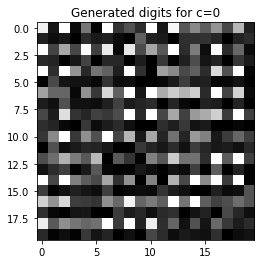

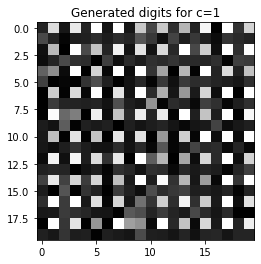

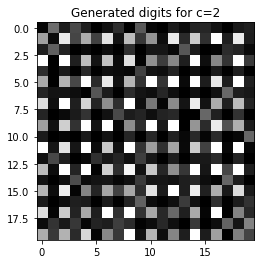

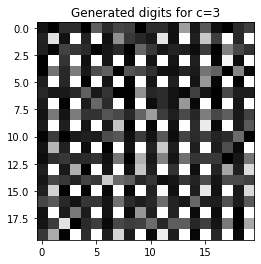

In [10]:
print("Calibration run - floating model")
for k in range(4):
    show_samples(model_floating, data, config, k)

In [11]:
np.savetxt(config.save_dir + "/val_losses_means_50epochs_mock_1epoch_hw.txt", val_losses_means)
np.savetxt(config.save_dir + "/val_losses_50epochs_mock_1epoch_hw.txt", val_losses)

Loaded HW model
0.97	0.0	0.03	0.0
0.06	0.9	0.01	0.03
0.03	0.04	0.91	0.02
0.01	0.0	0.01	0.98


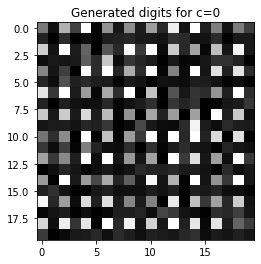

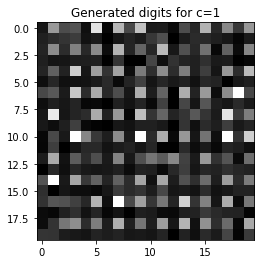

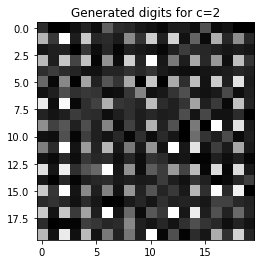

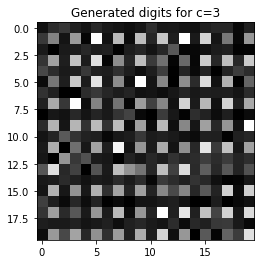

In [27]:
cpu_config = CONFIG
cpu_config.device = "cpu"
load_model = EXAMPLEcINN_hx(cpu_config)
#load_model.quantize()
load_model.load(cpu_config.save_dir + "hx_mock_example_cinn_5epochs_hw.pt")

print("Loaded HW model")
for k in range(4):
    show_samples(load_model, data, config, k)

Loaded Quantized model
1.0	0.0	0.0	0.0
0.0	1.0	0.0	0.0
0.0	0.0	1.0	0.0
0.0	0.0	0.0	1.0


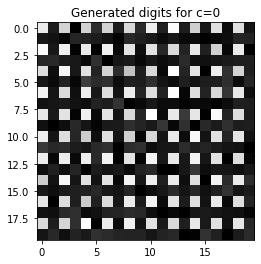

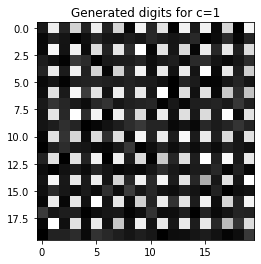

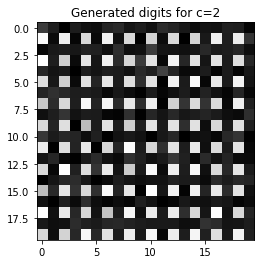

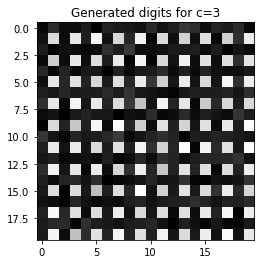

In [17]:
#print("Loaded Quantized model")
#for k in range(4):
#    show_samples(load_model, data, config, k)


#def calib_func(model, data=data, config=config):
#    for k in range(4):
#        show_samples(model, data, config, k)


In [8]:
max_out = 31
#weight = Parameter(torch.empty(features, **factory_kwargs),
#                                requires_grad=False)

x = torch.Tensor([[31, 0, -31], [-10.5, 0, 7]])
max_abs, _ = torch.max(torch.abs(x), axis=0)
#max_abs.fill_(max_abs.max())
print(max_abs)
max_abs[max_abs == 0] = max_out
print(max_abs)
weight = nn.Parameter(max_out / max_abs, requires_grad=False)
print(weight)
out = x * weight
print(out)
out_diag = F.linear(x, torch.diag(weight))
print(out_diag)

print("-------------------")
max_abss = torch.max(torch.abs(x))
factor = _hxtorch.constants.input_activation_max / max_abss if max_abss != 0 else 1
            #factor = torch.Tensor(_hxtorch.constants.input_activation_max).repeat(max_abs.size()) /  \
                #max_abs if max_abs != 0 else 1
print(x * factor)

tensor([31.,  0., 31.])
tensor([31., 31., 31.])
Parameter containing:
tensor([1., 1., 1.])
tensor([[ 31.0000,   0.0000, -31.0000],
        [-10.5000,   0.0000,   7.0000]])
tensor([[ 31.0000,   0.0000, -31.0000],
        [-10.5000,   0.0000,   7.0000]])
